<a href="https://colab.research.google.com/github/antsh3k/NN-learning/blob/master/3_Understand_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Classification

In [0]:
# SWITCH TO GPU

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch 

SEED = 15
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Get the data from github 

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/w-is-h/tmp/master/dataset.csv", encoding='cp1252')

In [0]:
df.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


# Print some statistics

In [0]:
shape = df.shape
cols = list(df.columns) # Must be a list
num_pos = np.sum(df['Sentiment'])
print("The shape of the dataset is: " + str(shape))
print("The columns are: " + str(cols))
print("Number of positive values: " + str(num_pos))

The shape of the dataset is: (25000, 2)
The columns are: ['SentimentText', 'Sentiment']
Number of positive values: 12500


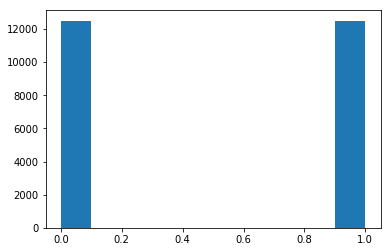

In [0]:
_ = plt.hist(df['Sentiment'])

###Get the $x,y$ values from the datset

In [0]:
x = df['SentimentText'].values
y = df['Sentiment'].values

###Look at x and check do we need to clean anything

Cleaning is not always necessary, but the more garbage we leave the more the Neural Network has to learn. So, if the cleaning process is easy - better to do it. Or get a gigantic dataset.

In [0]:
print(x[3])

watched horrid thing TV. Needless say one movies watch see much worse get. Frankly, don't know much lower bar go. <br /><br />The characters composed one lame stereo-type another, obvious attempt creating another "Bad News Bears" embarrassing say least.<br /><br />I seen prized turkeys time, reason list since "Numero Uno".<br /><br />Let put way, watched Vanilla Ice movie, bad funny. This...this...is even good.


In [0]:
# Remove mails and https links
pat_1 = r"(?:\@|https?\://)\S+"
# Remove tags
pat_2 = r'#\w+ ?'
# Combine into one regex
combined_pat = r'|'.join((pat_1, pat_2))
# Remove websites
www_pat = r'www.[^ ]+'
# Remove HTML tags
html_tag = r'<[^>]+>'
def data_cleaner(text):
  cleantags = ""
  try:
    stripped = re.sub(combined_pat, '', text)
    stripped = re.sub(www_pat, '', stripped)
    cleantags = re.sub(html_tag, '', stripped)
  except Exception as e:
    print(e)
    cleantags = "None"
  return cleantags

In [0]:
# : Run the cleaning function for each sentence in 'x' and save the results into a
#new variable x2
x2 = []
for doc in x:
  x2.append(data_cleaner(doc))


In [0]:
x_original = x
x = x2
print(x[3])

watched horrid thing TV. Needless say one movies watch see much worse get. Frankly, don't know much lower bar go. The characters composed one lame stereo-type another, obvious attempt creating another "Bad News Bears" embarrassing say least.I seen prized turkeys time, reason list since "Numero Uno".Let put way, watched Vanilla Ice movie, bad funny. This...this...is even good.


# SpaCy

We can use spacy to tokenize the text and further clean it.

In [0]:
import spacy
from spacy.attrs import LOWER
# Load the english model for spacy, the disable part is used to make it faster
nlp = spacy.load('en', disable=['ner', 'parser'])

###The nlp variable is an instance of a class that has the method \_\_call__ defined, which means it is a class that is callable

It returns an object that is a spacy representation of the input sentence



In [0]:
print("Type of the nlp variable is: " + str(type(nlp)))
doc = nlp("I was running yesterday.")
print("\nThe 'nlp' function returns: " + str(type(doc)))
print("\nIf we print the 'doc' variable we get the original input sentence: " + str(doc))

Type of the nlp variable is: <class 'spacy.lang.en.English'>

The 'nlp' function returns: <class 'spacy.tokens.doc.Doc'>

If we print the 'doc' variable we get the original input sentence: I was running yesterday.


###To access tokens we can loop over the document - this means the 'doc' class has an \_\_iter__ method defined

Look [here](https://github.com/explosion/spaCy/blob/9003fd25e5e966bd8d1b67a18f3ebd6010d6f718/spacy/tokens/doc.pyx) for the class definition

In [0]:
for token in doc:
  print(token)

I
was
running
yesterday
.


###Note that each token is a spacy object - not a string

In [0]:
print(type(doc[0])) # we can also index the doc object and get tokens

<class 'spacy.tokens.token.Token'>


###To get strings we use the .text property

In [0]:
print(type(doc[0].text))

<class 'str'>


In [0]:
# Each token has multiple properties, e.g. lemma_ - note the '_', that means print text
for token in doc:
  print(token.lemma_)
  print(token.is_stop)
  print()

-PRON-
True

be
True

run
False

yesterday
False

.
False



In [0]:
snt = "That was a very good movie, John"
# : Tokenize the sentence above and save the lemmatized strings into the 
#tmp variable

tmp = [t.lemma_ for t in nlp(snt)]
print(tmp)
# The output should be ['that', 'be', 'a', 'very', 'good', 'movie', ',', 'John']

['that', 'be', 'a', 'very', 'good', 'movie', ',', 'John']


In [0]:
# : Tokenize the sentence again and save the lemmatized strings into the 
#tmp variable, but skip stopwords and punctuation plus lowercase the lemmas, 
#print the tmp variable
tmp = [t.lemma_.lower() for t in nlp(snt) if not t.is_stop and not t.is_punct]
print(tmp)
# The output should be ['good', 'movie', 'john']

['good', 'movie', 'john']


# Split sentences into tokens and lowercase

In [0]:
# Print the first sentence
print(x[0])

first think another Disney movie, might good, it's kids movie. watch it, can't help enjoy it. ages love movie. first saw movie 10 8 years later still love it! Danny Glover superb could play part better. Christopher Lloyd hilarious perfect part. Tony Danza believable Mel Clark. can't help, enjoy movie! give 10/10!


In [0]:
# : Lemmatize and split each sentence in our dataset 'x', save the new
#lemmatized strings into the tok_snts variable. Skip punctuation and stopwords plus lowercase lemmas
tok_snts = []
for snt in x:
  tkns = [tkn.lemma_.lower() for tkn in nlp(snt) if not tkn.is_punct]
  tok_snts.append(tkns)
# Save back
x = tok_snts
# Print the first sentence
print(x[0])

['first', 'think', 'another', 'disney', 'movie', 'may', 'good', '-pron-', 'be', 'kid', 'movie', 'watch', '-pron-', 'can', 'not', 'help', 'enjoy', '-pron-', 'age', 'love', 'movie', 'first', 'see', 'movie', '10', '8', 'year', 'later', 'still', 'love', '-pron-', 'danny', 'glover', 'superb', 'could', 'play', 'part', 'better', 'christopher', 'lloyd', 'hilarious', 'perfect', 'part', 'tony', 'danza', 'believable', 'mel', 'clark', 'can', 'not', 'help', 'enjoy', 'movie', 'give', '10/10']


# Train word2vec

In [0]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

from gensim.models import Word2Vec
w2v = Word2Vec(x, size=300, window=6, min_count=4, workers=4)

#Similarity

We can now easily calculate word similarity using the `w2v.wv.most_similar()` function

In [0]:
w2v.wv.most_similar("bad")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('terrible', 0.7666038274765015),
 ('awful', 0.760027289390564),
 ('horrible', 0.73488450050354),
 ('suck', 0.712145209312439),
 ('worst', 0.7115403413772583),
 ('lousy', 0.6652932167053223),
 ('stupid', 0.6638615131378174),
 ('crappy', 0.6453804969787598),
 ('good', 0.6416094303131104),
 ('dreadful', 0.6223640441894531)]

#Get vectors

To get a vector for a word 'w' we can use the `w2v.wv.get_vector(w)` function

In [0]:
#To check is a word in our vocab we use:
if 'bad' in w2v.wv:
  print(w2v.wv.get_vector("bad"))

[-1.9930603e-01 -7.1830708e-01  4.3662372e-01  3.7881717e-01
 -5.5523425e-01  3.8440472e-01  1.4767395e+00 -2.6020375e-01
 -6.6382289e-01  5.6127882e-01 -1.1903995e+00  3.2087913e-01
 -4.2468601e-01  4.9083146e-01 -2.1801984e-01  5.3348470e-01
 -5.3254777e-01 -3.9537117e-01 -9.2829889e-01  1.3717705e+00
 -3.5480502e-01 -1.8207449e-01 -9.9948637e-02 -7.4317539e-01
 -7.3766977e-01  1.5350636e+00  2.2298485e-01  1.5597947e-01
  6.9809717e-01  6.5537530e-01  1.8340760e-01 -2.3912665e-01
  6.8455374e-01  7.6289302e-01 -1.4322363e+00 -1.6938481e+00
 -3.1448212e-01 -4.2879599e-01  1.2794785e+00 -1.0271571e+00
 -8.2129651e-01  1.2379475e+00  1.5273639e+00  3.4195292e-01
 -3.8150558e-01  1.6041555e-01  9.5072651e-01  1.0753525e+00
 -3.3933330e-01  3.7714341e-01 -4.7700089e-01  1.3936623e+00
 -6.1721593e-01  5.6903267e-01 -7.2206241e-01  4.7973052e-01
 -9.2810953e-01  1.2970347e+00  1.0000376e+00 -9.4042027e-01
 -2.3078531e-01 -7.4820411e-01  9.0098399e-01  1.0505563e+00
 -7.4888968e-01  1.75008

# Convert each sentence into the average sum of the vector representations of its tokens

Save the results into a new variable x_emb

In [0]:
# 

# x_emb - embedded sentences
x_emb = np.zeros((len(x), 300))
# Loop over sentences
for i_snt, snt in enumerate(x):
  cnt = 0
  # Loop over the words of a sentence
  for i_word, word in enumerate(snt):
    if word in w2v.wv:
      x_emb[i_snt] += w2v.wv.get_vector(word)
      cnt += 1
  if cnt > 0:
    x_emb[i_snt] = x_emb[i_snt] / cnt
    

In [0]:
# Get torch stuff
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.metrics

# Split the dataset into train/test/dev

In [0]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

inds = np.random.permutation(len(x))
inds_train = inds[0:int(0.8*len(x))]
inds_test = inds[int(0.8*len(x)):int(0.9*len(x))]
inds_dev = inds[int(0.9*len(x)):]

# 80% of the dataset
x_train = x_emb[inds_train]
y_train = y[inds_train]
x_train_w = np.array(x)[inds_train]
x_train_o = np.array(x_original)[inds_train]

# 10% of the dataset
x_test = x_emb[inds_test]
y_test = y[inds_test]

# 10% of the dataset
x_dev = x_emb[inds_dev]
y_dev = y[inds_dev]

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

x_dev = torch.tensor(x_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev.reshape(-1, 1), dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

#Build the network

In [0]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# : Set the device to 'cuda'
device = torch.device('cuda')

# : Build a network with 4 layers:
#1: 150 neurons and ReLU activation (300 inputs)
#2: 70 neurons and ReLU activation
#3: 25 neurons and ReLU activation
#4: 1 neuron and sigmoid activation
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(300, 150)
      self.fc2 = nn.Linear(150, 70)
      self.fc3 = nn.Linear(70, 25)
      self.fc4 = nn.Linear(25, 1)
      
      self.d1 = nn.Dropout(0.5)
      
    def forward(self, x):
      x = self.d1(torch.relu(self.fc1(x)))
      x = self.d1(torch.relu(self.fc2(x)))
      x = self.d1(torch.relu(self.fc3(x)))
      x = torch.sigmoid(self.fc4(x))
      return x

In [0]:
# Create the network and get BCE loss
net = Net()
criterion = nn.BCELoss()

# : Make a SGD optimizer with lr=0.002 and momentum=0.99
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.99)
# : Move the net to the device
net.to(device)

Net(
  (fc1): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=70, bias=True)
  (fc3): Linear(in_features=70, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
  (d1): Dropout(p=0.5)
)

# Train

In [0]:
# Move data to the right device
x_train = x_train.to(device)
y_train = y_train.to(device)

x_dev = x_dev.to(device)
y_dev = y_dev.to(device)

x_train = x_train.to(device)
y_train = y_train.to(device)

In [0]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

net.train()
losses = []
accs = []
accs_dev = []
for epoch in range(5000):  # do 10,000 epochs 
  # : zero the gradients on the optimizer
  optimizer.zero_grad()

  # : Calculate the forward pass 
  outputs = net(x_train)
  # : Calculate the loss
  loss = criterion(outputs, y_train)
  # : Backward pass
  loss.backward()
  # : Optimize/Update parameters
  optimizer.step()
  
  # Track the changes - This is normally done using tensorboard or similar
  losses.append(loss.item())
  accs.append(sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in outputs.cpu().detach().numpy()], y_train.cpu().numpy()))

  # print statistics
  if epoch % 500 == 0:
      net.eval()
      acc = sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in outputs.cpu().detach().numpy()], y_train.cpu().numpy())
      
      outputs_dev = net(x_dev)
      acc_dev = sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in outputs_dev.cpu().detach().numpy()], y_dev.cpu().numpy())
      accs_dev.append(acc_dev)
      
      print("Epoch: {:4} Loss: {:.5f} Acc: {:.3f} Acc Dev: {:.3f}".format(epoch, loss.item(), acc, acc_dev))
      net.train()
print('Finished Training')

Epoch:    0 Loss: 0.69569 Acc: 0.502 Acc Dev: 0.484
Epoch:  500 Loss: 0.47002 Acc: 0.800 Acc Dev: 0.832
Epoch: 1000 Loss: 0.39615 Acc: 0.835 Acc Dev: 0.844
Epoch: 1500 Loss: 0.37714 Acc: 0.847 Acc Dev: 0.851
Epoch: 2000 Loss: 0.36212 Acc: 0.855 Acc Dev: 0.853
Epoch: 2500 Loss: 0.34938 Acc: 0.863 Acc Dev: 0.857
Epoch: 3000 Loss: 0.34264 Acc: 0.868 Acc Dev: 0.858
Epoch: 3500 Loss: 0.32747 Acc: 0.875 Acc Dev: 0.857
Epoch: 4000 Loss: 0.31297 Acc: 0.879 Acc Dev: 0.859
Epoch: 4500 Loss: 0.29849 Acc: 0.888 Acc Dev: 0.862
Finished Training


In [0]:
# Switch to eval mode 
net.eval()
net.to(device)
print("Predicted value: " + str(net(torch.tensor(x_emb[4], dtype=torch.float32).to(device))))
print("Real value: " + str(y[4]))
print("Input sentence: " + df['SentimentText'].iloc[4])

Predicted value: tensor([0.8760], device='cuda:0', grad_fn=<SigmoidBackward>)
Real value: 1
Input sentence: truly enjoyed film. acting terrific plot. Jeff Combs talent recognized for. part flick would change ending. death creature far gruesome Sci Fi Channel.<br /><br />There interesting religious messages film. Jeff Combs obviously played Messiah figure creature (or shark prefer) represented anti-Chirst. particularly frightening scenes 'end world feel'. noticed third viewing classic creature feature. know many people won't get references Christianity, watch close you'll get it.


#Go back and add dropout

#Interpretability

In [0]:
# Make a small network with one layer
device = torch.device('cuda')
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(300, 1)
       
    def forward(self, x):
      x = torch.sigmoid(self.fc1(x))
      return x
net = Net()
net.to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99)
for epoch in range(4000):  # do 10,000 epochs 
  # zero the gradients
  optimizer.zero_grad()

  # Forward 
  outputs = net(x_train)
  # Calculate error
  loss = criterion(outputs, y_train)
  # Backward
  loss.backward()
  # Optimize/Update parameters
  optimizer.step()
  
  # Track the changes - This is normally done using tensorboard or similar
  losses.append(loss.item())

  # print statistics
  if epoch % 500 == 0:
      acc = sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in outputs.cpu().detach().numpy()], y_train.cpu().numpy())
      
      outputs_dev = net(x_dev)
      acc_dev = sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in outputs_dev.cpu().detach().numpy()], y_dev.cpu().numpy())
      
      print("Epoch: {:4} Loss: {:.5f} Acc: {:.3f} Acc Dev: {:.3f}".format(epoch, loss.item(), acc, acc_dev))

print('Finished Training')

Epoch:    0 Loss: 0.70144 Acc: 0.409 Acc Dev: 0.414
Epoch:  500 Loss: 0.45068 Acc: 0.807 Acc Dev: 0.816
Epoch: 1000 Loss: 0.41426 Acc: 0.825 Acc Dev: 0.834
Epoch: 1500 Loss: 0.39950 Acc: 0.831 Acc Dev: 0.835
Epoch: 2000 Loss: 0.39118 Acc: 0.836 Acc Dev: 0.836
Epoch: 2500 Loss: 0.38579 Acc: 0.839 Acc Dev: 0.836
Epoch: 3000 Loss: 0.38200 Acc: 0.840 Acc Dev: 0.838
Epoch: 3500 Loss: 0.37918 Acc: 0.841 Acc Dev: 0.840
Finished Training


In [0]:
# Print the prediction of the first 30 sentences
for i in range(30):
  out = net(x_train[i])
  print(i, out)

0 tensor([0.2452], device='cuda:0', grad_fn=<SigmoidBackward>)
1 tensor([0.2832], device='cuda:0', grad_fn=<SigmoidBackward>)
2 tensor([0.1570], device='cuda:0', grad_fn=<SigmoidBackward>)
3 tensor([0.0777], device='cuda:0', grad_fn=<SigmoidBackward>)
4 tensor([0.0066], device='cuda:0', grad_fn=<SigmoidBackward>)
5 tensor([0.1787], device='cuda:0', grad_fn=<SigmoidBackward>)
6 tensor([0.7117], device='cuda:0', grad_fn=<SigmoidBackward>)
7 tensor([0.0027], device='cuda:0', grad_fn=<SigmoidBackward>)
8 tensor([0.0440], device='cuda:0', grad_fn=<SigmoidBackward>)
9 tensor([0.0037], device='cuda:0', grad_fn=<SigmoidBackward>)
10 tensor([0.6430], device='cuda:0', grad_fn=<SigmoidBackward>)
11 tensor([0.2967], device='cuda:0', grad_fn=<SigmoidBackward>)
12 tensor([0.9493], device='cuda:0', grad_fn=<SigmoidBackward>)
13 tensor([0.8238], device='cuda:0', grad_fn=<SigmoidBackward>)
14 tensor([0.0053], device='cuda:0', grad_fn=<SigmoidBackward>)
15 tensor([0.2821], device='cuda:0', grad_fn=<Sigm

In [0]:
# Set the 'i_snt' to high prob
i_snt = 25

In [0]:
prod = []
# Take the weights of our layer
we = net.fc1.weight.detach().cpu().numpy()[0]
# For each word in the dataset check how much did it contribute to the 
#final classification
for ind, word in enumerate(x_train_w[i_snt]):
  if word in w2v:
    prod.append(np.dot(we, w2v.wv.get_vector(word)))
  else:
    prod.append(0)
    
# Sort the contributions
srt = np.argsort(prod)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys


In [0]:
print(x_train_o[i_snt].replace("<br /><br />", "\n"))
print()
# print the top 10 words that contributed the most
for i in range(1, 30):
  print(x_train_w[i_snt][srt[-i]], prod[srt[-i]])

1954 Marlon Brando hot actor performances Streetcar Named Desire Waterfront. Frank Sinatra yet re-invent silver screen. Sinatra's portrayal erstwhile Nathan Detroit, helped re-establish Sinatra fans.
It great screen version great play choices leads support players terrific. Imagine movie Brando sings? one singing role portrayed Sky Masterson. addition female leads, Jean Simmons Vivian Blaine(replaying stage role Nathan's long suffering girlfriend Adelade), put superlative efforts. Special mention goes great Stubby Kaye(as Nicely Nicely), due respect Eric Clapton, one's version Rockin' Boat even comes close Stubby's. Sheldon Leonard, would go fame TV producer shows Danny Thomas Show Dick Van Dyke Show "Harry Horse" wonders, B.S.Pulley excellent harsh mannered rough talking "Big Julie", even Regis Toomey offers excellence "Brother Arvide".
It one fun musicals see, good comedy, get Sinatra Brando. Soooooo "Luck Lady Tonight" brother..."it's dice"

great 36.186264
great 36.186264
great 36.

In [0]:
review1 = "That was not a good movie and my friend was there"
review2 = "That was a good movie and my friend was not there"

In [0]:
print(review1)
# Tokenize the review using spacy - same as we have done above
tkns = [tkn.lemma_.lower() for tkn in nlp(review1) if not tkn.is_punct]
# Convert the tokens to vectors and save into an array
vecs = [w2v.wv.get_vector(t) for t in tkns]
emb = torch.tensor(np.average(vecs, axis=0)).to(device)
net(emb)

That was not a good movie and my friend was there


tensor([0.8837], device='cuda:0', grad_fn=<SigmoidBackward>)

In [0]:
print(review2)
# Tokenize the review using spacy - same as we have done above
tkns = [tkn.lemma_.lower() for tkn in nlp(review2) if not tkn.is_punct]
# Convert the tokens to vectors and save into an array
vecs = [w2v.wv.get_vector(t) for t in tkns]
emb = torch.tensor(np.average(vecs, axis=0)).to(device)
net(emb)

That was a good movie and my friend was not there


tensor([0.8837], device='cuda:0', grad_fn=<SigmoidBackward>)

In [0]:
# TODO: print 3 examples where the model made a mistake
#x_train_o - contains the original text
#x_train - contains the embeding for each review in x_train_o
#y_train - contains the ground truth

In [0]:
for i in range(len(x_train_o)):
  text = x_train_o[i]
  emb = x_train[i]
  ground_truth = y_train[i]
  
  prediction = net(emb)
  prediction = prediction.detach().cpu().numpy()[0]
  if prediction < 0.01 and ground_truth == 1: # This is done to remove the extreme examples from the training or testing dataset
    print(text)
    print()

Actually liked movie very, much. it`s plot, acting, jokes, no. liked it, it`s one worse movies ever created. It`s lame, bad, becomes terribly funny. jokes actually cool, rest makes pray unemployment scriptwriter. "Men white" dumb stupid, two things. Turn TV roll floor laughing (beer helps lot:). chose second option.

low rating? really don't get it... bad acting? bad dialogue? Well, cares things cheesy low-budget horror movies? Seriously, acting dialogue isn't important movies. People hate movies bad acting bad dialogue shouldn't allowed rate cheesy low-budget movies. movies shouldn't taken seriously. Period.<br /><br />Anyway, time talk movie, right? Well, loved it! bought expected gorefest, it's gorefest gore pretty bad (most time it's animal guts placed body actors that's lame), didn't really care movie hilarious! characters hilarious, acting hilarious (bad acting GOOD thing cheesy low-budget horror movies), dialogue hilarious (bad dialogue GOOD thing cheesy low-budget horror movies

# Let's switch to batches

In [0]:
# This will batch the dataset through the model. Stochastic gradient decent benifits for batch processing

device = torch.device('cuda')
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(300, 1)
       
    def forward(self, x):
      x = torch.sigmoid(self.fc1(x))
      return x
net = Net()
net.to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99)



batch_size = 1000
num_batches = int(np.ceil(len(x_train)/batch_size)) #TODO: Calculate the number of batches based on x_train size and batch_size
for epoch in range(4000):  # do 10,000 epochs 
  for i in range(num_batches): #loop over all the batches
    start = i*batch_size
    end = (i+1) * batch_size
    x_train_batch =  x_train[start:end] #? Get batch_size examples from x_train
    y_train_batch = y_train[start:end] #? Get batch_size examples from y_train
    # zero the gradients
    optimizer.zero_grad()

    # Forward 
    outputs = net(x_train_batch)
    # Calculate error
    loss = criterion(outputs, y_train_batch)
    # Backward
    loss.backward()
    # Optimize/Update parameters
    optimizer.step()

    # Track the changes - This is normally done using tensorboard or similar
    losses.append(loss.item())

    # print statistics
    if epoch % 500 == 0:
        outputs = net(x_train)
        acc = sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in outputs.cpu().detach().numpy()], y_train.cpu().numpy())

        outputs_dev = net(x_dev)
        acc_dev = sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in outputs_dev.cpu().detach().numpy()], y_dev.cpu().numpy())

        print("Epoch: {:4} Loss: {:.5f} Acc: {:.3f} Acc Dev: {:.3f}".format(epoch, loss.item(), acc, acc_dev))

print('Finished Training')

Epoch:    0 Loss: 0.70349 Acc: 0.495 Acc Dev: 0.513
Epoch:    0 Loss: 0.70379 Acc: 0.495 Acc Dev: 0.513
Epoch:    0 Loss: 0.70582 Acc: 0.495 Acc Dev: 0.513
Epoch:    0 Loss: 0.70130 Acc: 0.495 Acc Dev: 0.513
Epoch:    0 Loss: 0.70239 Acc: 0.495 Acc Dev: 0.512
Epoch:    0 Loss: 0.70465 Acc: 0.494 Acc Dev: 0.512
Epoch:    0 Loss: 0.70213 Acc: 0.494 Acc Dev: 0.512
Epoch:    0 Loss: 0.69870 Acc: 0.494 Acc Dev: 0.512
Epoch:    0 Loss: 0.69715 Acc: 0.494 Acc Dev: 0.512
Epoch:    0 Loss: 0.69801 Acc: 0.494 Acc Dev: 0.512
Epoch:    0 Loss: 0.70235 Acc: 0.494 Acc Dev: 0.512
Epoch:    0 Loss: 0.70094 Acc: 0.494 Acc Dev: 0.512
Epoch:    0 Loss: 0.69891 Acc: 0.494 Acc Dev: 0.511
Epoch:    0 Loss: 0.69810 Acc: 0.494 Acc Dev: 0.510
Epoch:    0 Loss: 0.69266 Acc: 0.494 Acc Dev: 0.511
Epoch:    0 Loss: 0.70213 Acc: 0.494 Acc Dev: 0.511
Epoch:    0 Loss: 0.69584 Acc: 0.495 Acc Dev: 0.510
Epoch:    0 Loss: 0.70137 Acc: 0.495 Acc Dev: 0.510
Epoch:    0 Loss: 0.69775 Acc: 0.495 Acc Dev: 0.510
Epoch:    0 